In [11]:
import pandas as pd
import spacy
from nltk.corpus import stopwords
from sklearn.pipeline import Pipeline
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer
import numpy as np
import joblib
import matplotlib.pyplot as plt
import nltk
import string
import wordcloud
import seaborn as sns
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer

In [6]:
english_stemmer = SnowballStemmer('english')
stop_words = set(stopwords.words('english'))
punctuation = set(string.punctuation)
nltk.download("punkt")
nlp = spacy.load("en_core_web_sm")


[nltk_data] Downloading package punkt to
[nltk_data]     /Users/amgiraldov/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [7]:
df = pd.read_csv('data_videos.csv', sep = "|")
df = df[df['description'].notnull()]

In [8]:
def tokenize1(text):
    doc = nlp(text)
    words = [t.orth_ for t in doc if not t.is_punct | t.is_stop]
    words = [w for w in words if not w in stop_words] 
    lexical_tokens = [t.lower() for t in words if t.isalpha()]
    return lexical_tokens

In [15]:
stop_words = nltk.corpus.stopwords.words('english')
newStopWords = ['https', 'com', 'www', 'http', 'ly', 'bit', 'us', 'follow', 'suscribe', 'channel',
               'watch', 'youtu', 'facebook', 'twitter', 'instagram', 'de', 'youtube', 'subscribe', 'video']
stop_words.extend(newStopWords)

In [12]:
def get_top_n_words(corpus, n=1,k=1):
    vec = CountVectorizer(ngram_range=(k,k), stop_words = stop_words).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

In [14]:
common_words = get_top_n_words(df['title'], 30, 1)
for word, freq in common_words:
    print(word, freq)

covid 2143
19 1434
news 1267
mask 989
coronavirus 843
face 766
2021 729
vaccine 679
new 628
live 545
dr 529
full 457
de 398
make 383
india 352
tutorial 331
vs 329
life 309
world 307
april 300
diy 297
documentary 295
bbc 292
update 285
corona 280
2020 275
best 271
prince 266
easy 266
lockdown 263


In [17]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(ngram_range=(1,1), use_idf=True, tokenizer = tokenize1)
X = vectorizer.fit_transform(df["title"])

In [94]:
X

<19899x27710 sparse matrix of type '<class 'numpy.float64'>'
	with 178670 stored elements in Compressed Sparse Row format>

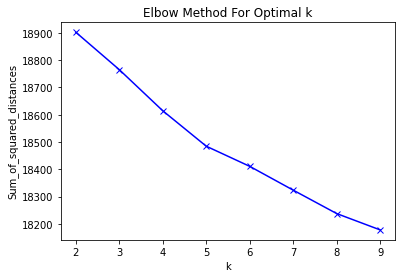

In [118]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
Sum_of_squared_distances = []
K = range(2,10)
for k in K:
   km = KMeans(n_clusters=k, max_iter=200, n_init=10)
   km = km.fit(X)
   Sum_of_squared_distances.append(km.inertia_)
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

In [19]:
true_k = 7
from sklearn.cluster import KMeans
model = KMeans(n_clusters=true_k, init='k-means++', max_iter=200, n_init=10)
model.fit(X)
labels=model.labels_
wiki_cl=pd.DataFrame(list(zip(df["title"],labels)),columns=['title','cluster'])
print(wiki_cl)

                                                   title  cluster
0      White House Covid-19 Response Team Holds Brief...        6
1      Covid spreading faster in India than anywhere ...        6
2      COVID-19 ‘spreading like wildfire’ despite inc...        0
3      Covid-19: Nearly 100,000 catching virus every ...        6
4      What are the Covid risks and how do you stay s...        6
...                                                  ...      ...
19894     System Of A Down - Chop Suey! (Official Video)        0
19895  Cat Never Gives Up Her Disabled Child Who Cant...        0
19896         How sugar affects the brain - Nicole Avena        0
19897  7 Signs Of Unhealthy Gut And How To Improve Gu...        0
19898           Longevity & Why I now eat One Meal a Day        0

[19899 rows x 2 columns]


Cluster: 0
Titles


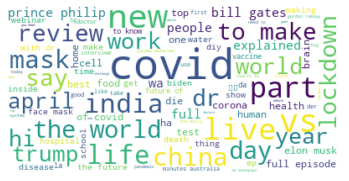

Cluster: 1
Titles


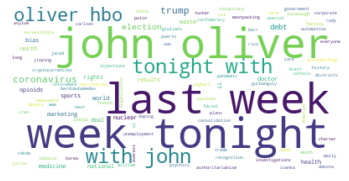

Cluster: 2
Titles


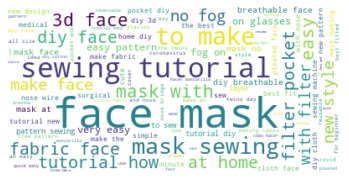

Cluster: 3
Titles


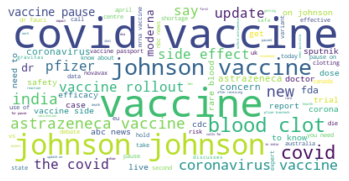

Cluster: 4
Titles


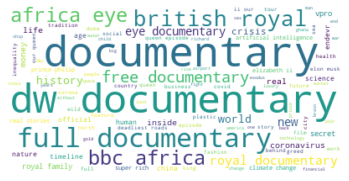

Cluster: 5
Titles


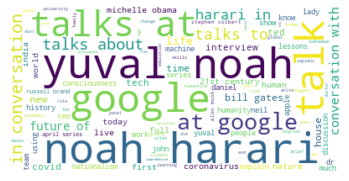

Cluster: 6
Titles


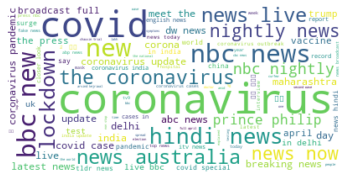

In [20]:
from wordcloud import WordCloud
result={'cluster':labels,'wiki':df["title"]}
result=pd.DataFrame(result)
for k in range(0,true_k):
   s=result[result.cluster==k]
   text=s['wiki'].str.cat(sep=' ')
   text=text.lower()
   text=' '.join([word for word in text.split()])
   wordcloud = WordCloud(max_font_size=50, max_words=100, stopwords=stop_words,background_color="white").generate(text)
   print('Cluster: {}'.format(k))
   print('Titles')
   titles=wiki_cl[wiki_cl.cluster==k]['title']         
   #print(titles.to_string(index=False))
   plt.figure()
   plt.imshow(wordcloud, interpolation="bilinear")
   plt.axis("off")
   plt.show()

In [26]:
# SEcond alternative


In [29]:
# Convert sparse matrix to gensim corpus.
from gensim.corpora.dictionary import Dictionary
from gensim import models
import gensim

In [30]:
corpus = gensim.matutils.Sparse2Corpus(X, documents_columns=False)
# Mapping from word IDs to words (To be used in LdaModel's id2word parameter)
id_map = dict((v, k) for k, v in vectorizer.vocabulary_.items())
# Use the gensim.models.ldamodel.LdaModel constructor to estimate 
# LDA model parameters on the corpus, and save to the variable `ldamodel`
ldamodel = gensim.models.LdaMulticore(corpus=corpus, id2word=id_map, passes=2,
                                               random_state=5, num_topics=10, workers=2)

In [31]:
for idx, topic in ldamodel.print_topics(-1):
    print("Topic: {} \nWords: {}".format(idx, topic))
    print("\n")

Topic: 0 
Words: 0.025*"mask" + 0.020*"face" + 0.010*"tutorial" + 0.009*"sewing" + 0.008*"diy" + 0.008*"easy" + 0.005*"computerphile" + 0.005*"microscopy" + 0.005*"microscope" + 0.004*"new"


Topic: 1 
Words: 0.003*"jordan" + 0.003*"covid" + 0.003*"vaccine" + 0.003*"second" + 0.003*"peterson" + 0.003*"china" + 0.003*"philips" + 0.003*"elon" + 0.003*"news" + 0.003*"musk"


Topic: 2 
Words: 0.010*"news" + 0.006*"live" + 0.005*"prince" + 0.004*"hindi" + 0.004*"bengal" + 0.003*"philip" + 0.003*"पर" + 0.003*"die" + 0.003*"coronavirus" + 0.003*"update"


Topic: 3 
Words: 0.005*"april" + 0.004*"news" + 0.003*"covid" + 0.003*"new" + 0.003*"cases" + 0.003*"day" + 0.002*"coronavirus" + 0.002*"types" + 0.002*"lockdown" + 0.002*"nbc"


Topic: 4 
Words: 0.004*"covid" + 0.003*"vaccines" + 0.003*"vaccine" + 0.003*"coronavirus" + 0.003*"dr" + 0.003*"life" + 0.003*"news" + 0.003*"new" + 0.002*"world" + 0.002*"iphone"


Topic: 5 
Words: 0.007*"news" + 0.005*"week" + 0.005*"john" + 0.005*"tonight" + 0.00

In [32]:
df["cluster"] = labels


In [34]:
df.to_csv("cluster.csv")

In [36]:
df['cluster'].value_counts()

0    16638
6     1584
3      619
2      466
4      288
5      171
1      133
Name: cluster, dtype: int64

In [ ]:
df['cluster'].value_counts()

In [37]:
df3 = df[df['cluster'] == 3]

In [39]:
df3 = df3.title

In [40]:
df3

21       New questions over safety of AstraZeneca vacci...
22       AstraZeneca vaccine: How do you weigh up the r...
73       Several states report adverse reactions to Joh...
81       Sites pause using Johnson & Johnson vaccine af...
164      The COVID Vaccine: Debates, Distrust, and Disp...
                               ...                        
19033    Vaccine passports place all of our freedoms un...
19301    MyPillow Mike’s 48-Hour Yellathon & Vaccine He...
19411          The Vaccine Passport Debate | April 9, 2021
19936    All U.S. Adults Now Eligible for Vaccine; GOP ...
20094    Johnson & Johnson Vaccine Struggles, Apple’s S...
Name: title, Length: 619, dtype: object

In [42]:
# Program to show various ways to read and
# write data in a file.
file1 = open("/Users/amgiraldov/Desktop/myfile.txt","w")
file1.writelines(df3)
file1.close() #to change file access modes